In [2]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from seqeval.metrics import precision_score, recall_score, f1_score

### Loading & Preprocessig Datasets

##### 1. ABSA Dataset

In [6]:
def preprocess_absa_dataset(folder_path):
  data = []
  for root, _, files in os.walk(folder_path):
    for file in files:
      if file.endswith(".json"):
        with open(os.path.join(root, file), "r", encoding="utf-8") as f:
          content = json.load(f)
          for entry in content:
            text = " ".join(entry["token"])
            aspects = []
            for asp in entry.get("aspects", []):
              term = " ".join(asp["term"])
              # If from/to not present, try to find in text
              try:
                from_idx = text.index(term)
                to_idx = from_idx + len(term)
              except ValueError:
                from_idx, to_idx = -1, -1
              aspects.append({"term": term, "from": from_idx, "to": to_idx})
            data.append({
              "text": text,
              "aspects": aspects,
              "no_aspect_mentioned": len(aspects) == 0
            })
  return data

In [7]:
absa_data = preprocess_absa_dataset(r"C:\Users\HP\Downloads\ABSA")

In [5]:
print(len(absa_data))
print(absa_data[15100])

35804
{'text': 'The flavors are very fresh and pretty inobtrusive , nothing flashy .', 'aspects': [{'term': 'flavors', 'from': 4, 'to': 11}], 'no_aspect_mentioned': False}


##### 2. Semeval2014 Dataset

In [8]:
def preprocess_semeval_dataset(folder_path):
  data = []
  for file in os.listdir(folder_path):
    if file.endswith(".csv"):
      df = pd.read_csv(os.path.join(folder_path, file))
      for _, row in df.iterrows():
        text = row["Sentence"]
        aspects = []
        if pd.notna(row["Aspect Term"]):
          aspects.append({
            "term": str(row["Aspect Term"]),
            "from": int(row["from"]),
            "to": int(row["to"])
          })
        # Check if text already exists in the previous row
        try:
          if data[-1]["text"] == text:
            data[-1]["aspects"].extend(aspects)
            continue
        except IndexError:
          pass
        data.append({
          "text": text,
          "aspects": aspects,
          "no_aspect_mentioned": len(aspects) == 0
        })
  return data


In [9]:
semeval_data = preprocess_semeval_dataset(r"C:\Users\HP\Downloads\Semeval2014")

In [8]:
print(len(semeval_data))
print(semeval_data[2])

4073
{'text': 'Love the food quality here but service was terrible', 'aspects': [{'term': 'food', 'from': 9, 'to': 13}, {'term': 'service', 'from': 29, 'to': 36}], 'no_aspect_mentioned': False}


##### 3. No Aspect Dataset

In [10]:
def preprocess_no_aspect_dataset(csv_path):
  df = pd.read_csv(csv_path)
  data = []
  for _, row in df.iterrows():
    data.append({
      "text": row["text"],
      "aspects": [],
      "no_aspect_mentioned": True
    })
  return data

In [11]:
noaspect_data = preprocess_no_aspect_dataset(r"C:\Users\HP\Downloads\aspect_training_no_aspect.csv")

In [11]:
len(noaspect_data)

813

### Tokenization & Data Pipeline

In [31]:
full_data = absa_data + semeval_data + noaspect_data
np.random.shuffle(full_data)
len(full_data)

40690

In [40]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

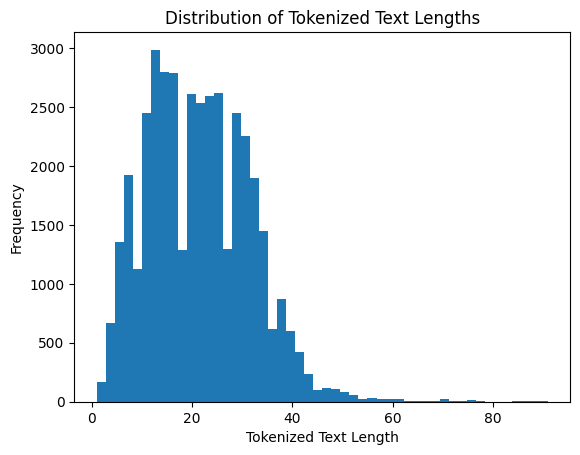

Max length: 91
Number of samples > 64: 86


'\nThis statistic shows that the maximum length of a tokenized text is 91\nwhile there is only 86 out of 40690 longer than 64.\nTherefore, choosing a token length of 128 for the data is inefficient,\nand you will increase the computational power and training time for nothing.\nBest choice is 64.\n'

In [ ]:
import matplotlib.pyplot as plt

lengths = [len(tokenizer.tokenize(item["text"])) for item in full_data]

plt.hist(lengths, bins=50)
plt.xlabel("Tokenized Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Tokenized Text Lengths")
plt.show()

print(f"Max length: {max(lengths)}")
print(f"Number of samples > 64: {sum(l > 64 for l in lengths)}")

"""
This statistic shows that the maximum length of a tokenized text is 91
while there is only 86 out of 40690 longer than 64.
Therefore, choosing a token length of 128 for the data is inefficient,
and you will increase the computational power and training time for nothing.
Best choice is 64.
"""

In [10]:
class AspectDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=64):
        self.data = data  # Raw data with original text
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        # Tokenize here with offset mapping
        encoding = self.tokenizer(
            item["text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
            return_offsets_mapping=True
        )
        
        # Create BIO labels using the text and offset mapping
        labels = self.create_bio_labels(
            item["text"], 
            item["aspects"], 
            encoding["offset_mapping"][0]
        )
        
        return {
            "input_ids": encoding["input_ids"][0].squeeze(),
            "attention_mask": encoding["attention_mask"][0].squeeze(),
            "labels": torch.tensor(labels, dtype=torch.long)
        }
    
    def create_bio_labels(self, text, aspects, offset_mapping):
        """
        Create BIO labels using character-level offsets
        """
        labels = [0] * len(offset_mapping)  # 0 for 'O' (Outside)
        
        for aspect in aspects:
            aspect_text = aspect["term"]
            start_char = aspect["from"]
            end_char = aspect["to"]
            
            # Find tokens that overlap with the aspect span
            for token_idx, (start_offset, end_offset) in enumerate(offset_mapping):
                if start_offset == 0 and end_offset == 0:  # Special tokens ([CLS], [SEP], [PAD])
                    continue
                    
                # Check if token overlaps with aspect span
                if start_offset < end_char and end_offset > start_char:
                    if start_offset >= start_char:  # Token starts within aspect
                        if labels[token_idx] == 0:  # Not yet labeled
                            # Check if this is the first token of the aspect
                            is_first_token = True
                            for prev_idx in range(token_idx):
                                if labels[prev_idx] != 0:  # Previous token is part of an aspect
                                    prev_start, prev_end = offset_mapping[prev_idx]
                                    if prev_start < end_char and prev_end > start_char:
                                        is_first_token = False
                                        break
                            
                            labels[token_idx] = 1 if is_first_token else 2  # 1 for 'B-', 2 for 'I-'
                        
        return labels

In [42]:
train_data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)
train_dataset = AspectDataset(train_data, tokenizer)
test_dataset = AspectDataset(test_data, tokenizer)

### Training

In [35]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels=3)  # O, B-ASP, I-ASP

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=-1)
  labels = p.label_ids

  # Convert to BIO tag lists
  id2label = {0: "O", 1: "B-ASP", 2: "I-ASP"}
  pred_tags = [[id2label[p] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(preds, labels)]
  true_tags = [[id2label[l] for (p, l) in zip(pred, label) if l != -100] for pred, label in zip(preds, labels)]

  return {
    "precision": precision_score(true_tags, pred_tags),
    "recall": recall_score(true_tags, pred_tags),
    "f1": f1_score(true_tags, pred_tags),
  }

In [43]:
training_args = TrainingArguments(
  output_dir="./aspect_extraction_model",
  num_train_epochs=3,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  eval_strategy="epoch",
  save_strategy="epoch",
  logging_dir="./logs",
  logging_steps=50,
  learning_rate=2e-5,
  weight_decay=0.01,
  report_to="none"
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

c:\Users\HP\anaconda3\envs\nlp-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.014000,0.010713,0.914484,0.948012,0.930946
2,0.007700,0.007610,0.940926,0.964016,0.952331
3,0.006000,0.007072,0.953584,0.966440,0.959969


c:\Users\HP\anaconda3\envs\nlp-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\HP\anaconda3\envs\nlp-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=12207, training_loss=0.012176835005095074, metrics={'train_runtime': 35728.3997, 'train_samples_per_second': 2.733, 'train_steps_per_second': 0.342, 'total_flos': 3189678346902528.0, 'train_loss': 0.012176835005095074, 'epoch': 3.0})

In [63]:
training_args = TrainingArguments(
  output_dir="./aspect_extraction_model",
  num_train_epochs=4,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  eval_strategy="epoch",
  save_strategy="epoch",
  logging_dir="./logs",
  logging_steps=50,
  learning_rate=2e-5,
  weight_decay=0.01,
  report_to="none"
)

trainer = Trainer(
  model=model,
  args=training_args,
  train_dataset=train_dataset,
  eval_dataset=test_dataset,
  compute_metrics=compute_metrics
)

trainer.train(resume_from_checkpoint="aspect_extraction_model\checkpoint-12207")

c:\Users\HP\anaconda3\envs\nlp-env\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
4,0.004900,0.007185,0.953021,0.970029,0.961450


TrainOutput(global_step=16276, training_loss=0.0009786580096674833, metrics={'train_runtime': 11886.4108, 'train_samples_per_second': 10.954, 'train_steps_per_second': 1.369, 'total_flos': 4252904462536704.0, 'train_loss': 0.0009786580096674833, 'epoch': 4.0})

### Evaluation

In [3]:
model = BertForTokenClassification.from_pretrained("aspect_extraction_model\checkpoint-12207")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [4]:
def convert_predictions_to_aspects(text, predictions, offset_mapping, input_ids, tokenizer):
  aspects = []
  current_aspect = None
  
  for i, (pred_label, (start_pos, end_pos)) in enumerate(zip(predictions, offset_mapping)):
    # Skip special tokens and padding
    if start_pos == 0 and end_pos == 0:
      continue
        
    token = tokenizer.decode([input_ids[i]], skip_special_tokens=True)
    
    if pred_label == 1:  # B- (Beginning of aspect)
      # Save previous aspect if exists
      if current_aspect is not None:
        aspects.append(current_aspect)
      
      # Start new aspect
      current_aspect = {
        "term": text[start_pos:end_pos],
        "from": start_pos,
        "to": end_pos,
        "tokens": [token]
      }
        
    elif pred_label == 2:  # I- (Inside aspect)
      if current_aspect is not None:
        # Extend current aspect
        current_aspect["term"] = text[current_aspect["from"]:end_pos]
        current_aspect["to"] = end_pos
        current_aspect["tokens"].append(token)
      
      else:
        current_aspect = {
          "term": text[start_pos:end_pos],
          "from": start_pos,
          "to": end_pos,
          "tokens": [token]
        }
        
    elif pred_label == 0:  # O (Outside)
      # End current aspect if exists
      if current_aspect is not None:
        aspects.append(current_aspect)
        current_aspect = None
  
  if current_aspect is not None:
    aspects.append(current_aspect)
  
  return aspects


In [5]:
def aspects_extraction(text, model, tokenizer, max_length=64):
  model.eval()
  encoding = tokenizer(
    text,
    truncation = True,
    padding = 'max_length',
    max_length = max_length,
    return_offsets_mapping = True,
    return_tensors = 'pt'
  )
  input_ids = encoding["input_ids"]
  attention_mask = encoding["attention_mask"]

  with torch.no_grad():
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=-1) # outputs.logits shape: [1, 64, 3]

  aspects = convert_predictions_to_aspects(text,
                                           predicted_labels[0].cpu().numpy(),
                                           encoding["offset_mapping"][0].cpu().numpy(),
                                           input_ids[0].cpu().numpy(),
                                           tokenizer)

  return aspects
  

In [7]:
def format_output(text, aspects):
  print(f"Text: {text}")
  print(f"Found {len(aspects)} aspects:")
  
  for i, aspect in enumerate(aspects, 1):
    print(f"  {i}. '{aspect['term']}'")
      
  print("-" * 50)

In [9]:
test_data = pd.read_csv(r"C:\Users\HP\Downloads\testing and evaluation\Restaurants_Test_Data_PhaseA.csv")
test_data = test_data.tail(5)
for _ , row in test_data.iterrows():
  aspects = aspects_extraction(row['Sentence'], model, tokenizer)
  format_output(row['Sentence'], aspects)

Text: Anyway, the owner was fake.
Found 1 aspects:
  1. 'owner'
--------------------------------------------------
Text: Owner is pleasant and entertaining.
Found 1 aspects:
  1. 'Owner'
--------------------------------------------------
Text: I have never in my life sent back food before, but I simply had to, and the waiter argued with me over this.
Found 2 aspects:
  1. 'food'
  2. 'waiter'
--------------------------------------------------
Text: Although the restaurant itself is nice, I prefer not to go for the food.
Found 1 aspects:
  1. 'food'
--------------------------------------------------
Text: Creamy appetizers--taramasalata, eggplant salad, and Greek yogurt (with cuccumber, dill, and garlic) taste excellent when on warm pitas.
Found 5 aspects:
  1. 'Creamy appetizers'
  2. '--taramasalata'
  3. ', eggplant salad'
  4. 'Greek yogurt (with cuccumber, dill, and garlic'
  5. 'warm pitas'
--------------------------------------------------
